In [1]:
#hide
from utils import *
from fastai2.vision.widgets import *

## Gathering data

In [2]:
key = '798ca8acf3924ea5aaefa5504ab8ff37'

In [3]:
search_images_bing

<function utils.search_images_bing(key, term, min_sz=128)>

In [4]:
results = search_images_bing(key, 'grizzly bear')
ims = results.attrgot('content_url')
len(ims)

150

In [5]:
results

(#150) [<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F43C8>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F4400>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F44A8>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F4550>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F45F8>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F46A0>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F4748>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F47F0>,<azure.cognitiveservices.search.imagesearch.models._models_py3.ImageObject object at 0x000001EAC85F4898>,<azure.cognitiveservices.search.imagesearch.mod

In [6]:
!ls images

chapter1_cat_example.jpg
grizzly.jpg
grizzly_0.jpg
grizzly_1.jpg
grizzly_2.jpg
grizzly_3.jpg


In [7]:
results.attrgot('content_url')[0:2]

(#2) ['https://upload.wikimedia.org/wikipedia/commons/e/e2/Grizzlybear55.jpg','http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']

In [8]:
#hide
ims = [results.attrgot('content_url')]

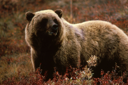

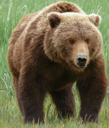

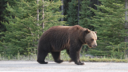

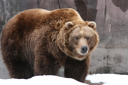

In [10]:
for indx in range(4):
    dest = 'images/grizzly_%1d.jpg'%indx
    download_url(ims[0][indx], dest)
    im = Image.open(dest)
    display(im.to_thumb(128,128))

In [11]:
!ls images

chapter1_cat_example.jpg
grizzly.jpg
grizzly_0.jpg
grizzly_1.jpg
grizzly_2.jpg
grizzly_3.jpg


In [12]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

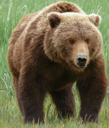

In [13]:
im = Image.open(dest)
im.to_thumb(128,128)

In [2]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    for bear_type_tmp in bear_types:
        dest = (path/bear_type_tmp)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{bear_type_tmp} bear')
        download_images(dest, urls=results.attrgot('content_url'))

In [15]:
!ls bears

black
grizzly
teddy


In [16]:
fns = get_image_files(path)
fns

(#427) [Path('bears/black/00000000.jpg'),Path('bears/black/00000001.JPG'),Path('bears/black/00000002.jpg'),Path('bears/black/00000003.jpg'),Path('bears/black/00000004.jpg'),Path('bears/black/00000005.JPG'),Path('bears/black/00000006.jpg'),Path('bears/black/00000007.jpg'),Path('bears/black/00000008.jpg'),Path('bears/black/00000009.jpg')...]

In [17]:
failed = verify_images(fns)
failed

(#0) []

In [18]:
len(failed)

0

In [19]:
failed.map(Path.unlink);

## From data to DataLoaders

In [3]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [5]:
bears.summary(path)

Setting-up type transforms pipelines
Found 404 items
2 datasets of sizes 283,121
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      bears\black\00000028.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=3872x2592
  Pipeline: parent_label -> Categorize
    starting from
      bears\black\00000028.jpg
    applying parent_label gives
      black
    applying Categorize gives
      TensorCategory(0, dtype=torch.int32)

Final sample: (PILImage mode=RGB size=3872x2592, TensorCategory(0, dtype=torch.int32))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=3872x2592, TensorCategory(0, dtype=torch.int32))
    applying Resize gives
      (PILImage m

In [6]:
path

Path('bears')

## Train model with augmentation

In [4]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path, num_workers=0)

In [8]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.672359,0.233374,0.099174,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.205618,0.099689,0.041322,00:27
1,0.151378,0.021039,0.016529,00:26
2,0.103184,0.005805,0.000000,00:27
3,0.079067,0.004652,0.000000,00:27
4,0.061873,0.005264,0.000000,00:27


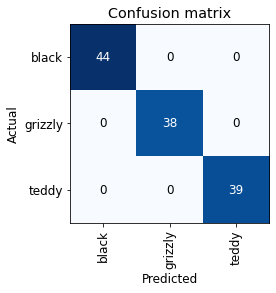

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

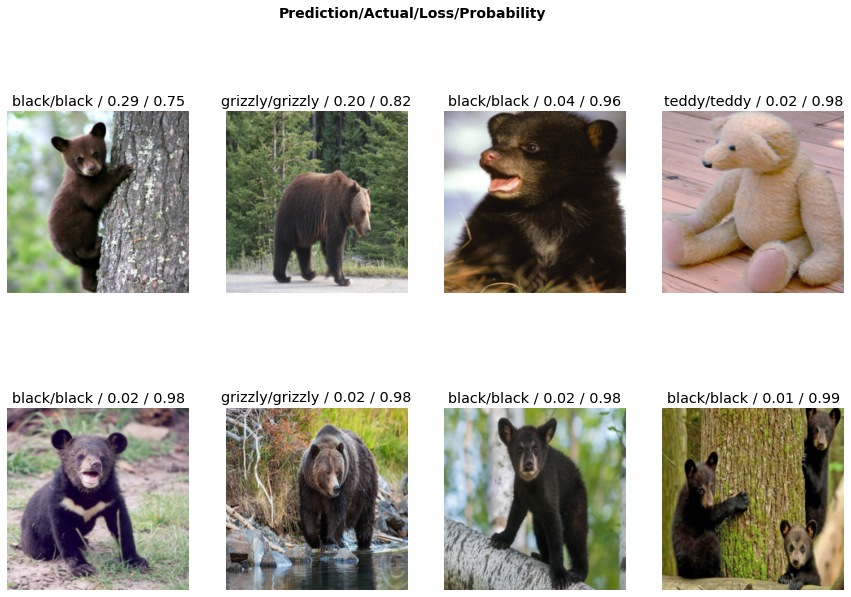

In [21]:
interp.plot_top_losses(8, figsize=(15,10))

In [70]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [65]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning your model into an online application

### Using the model for inference

In [22]:
learn.export(fname='bear_classifier_model.pkl')

In [23]:
path = Path()
path.ls(file_exts='.pkl')

(#3) [Path('bear_classifier_model.pkl'),Path('bear_classifier_model_old.pkl'),Path('export.pkl')]

In [24]:
learn_inf = load_learner(path/'bear_classifier_model.pkl')

In [25]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([3.8768e-05, 9.9996e-01, 4.3743e-08]))

In [26]:
learn_inf.dls.vocab

(#3) ['black','grizzly','teddy']